In [17]:
!pip install numpy pandas scikit-learn wandb

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance 
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import wandb

In [19]:
wandb.login(key="7908ef85b4611c7fa7bf2ae7dd6569e28c768d36")
run = wandb.init(project="distance_classification_project", settings=wandb.Settings(init_timeout=180))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
import glob

dataset_paths = glob.glob("/kaggle/input/*")
print("Available datasets:", dataset_paths)

Available datasets: ['/kaggle/input/distance-classification']


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


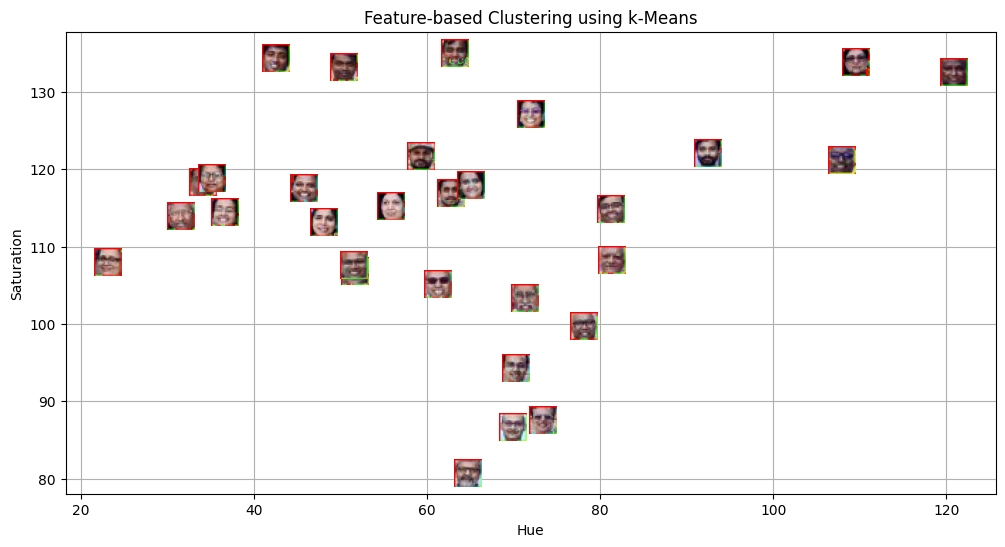

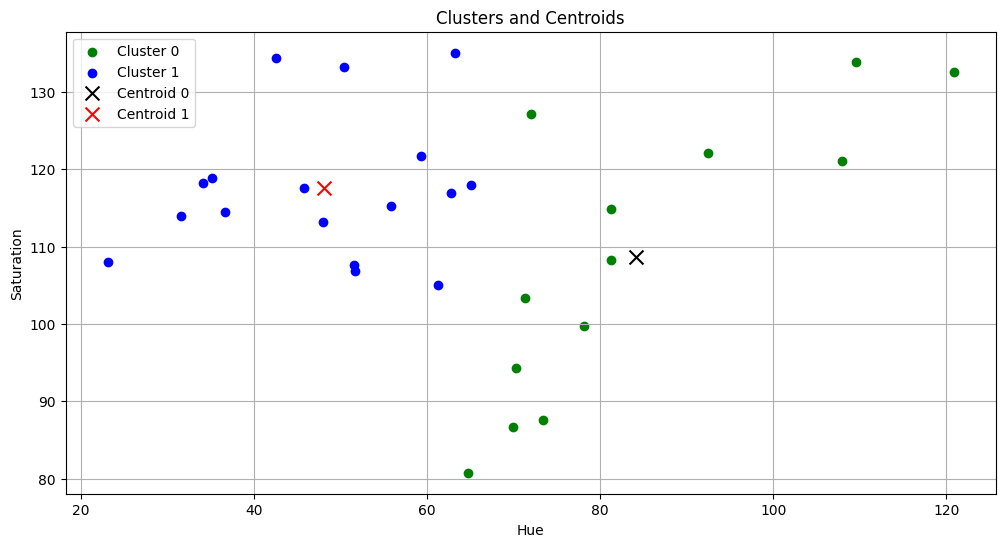

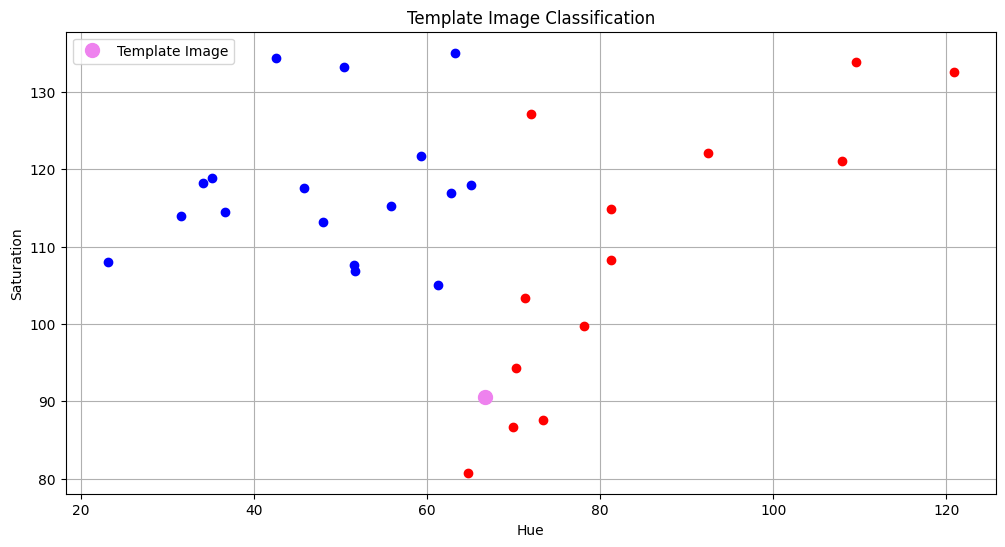


Report:
1. Common distance metrics: Euclidean, Manhattan, Minkowski, Cosine, Hamming.
2. Real-world applications: Face recognition, image retrieval, fraud detection, medical diagnosis, document classification.
3. Distance metrics explained:
   - Euclidean: Straight-line distance.
   - Manhattan: Sum of absolute differences.
   - Minkowski: Generalization of Euclidean and Manhattan.
   - Cosine Similarity: Measures cosine of the angle between vectors.
   - Hamming: Number of differing bits.
4. Cross-validation: Helps in assessing model performance by reducing bias/variance.
5. Variance and bias in KNN:
   - Low k: Low bias, high variance.
   - High k: Higher bias, lower variance.



report,Report:1. Common d...


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import wandb
import time

# ------------- Face Detection & Annotation -------------
# Read the main image
img = cv2.imread("./Plaksha_Faculty.jpg")
if img is None:
    raise FileNotFoundError("plaksha_Faculty.jpg not found. Please check the file path.")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Detect faces in the image (using defined min and max sizes)
faces_rect = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05, minNeighbors=4, minSize=(25,25), maxSize=(50,50))

# Annotate faces with rectangles and text
for (x, y, w, h) in faces_rect:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(img, "Face", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

# Log annotated image to WandB (convert BGR to RGB)
annotated_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
wandb.log({"annotated_faces": wandb.Image(annotated_img, caption="Detected Faces")})

# ------------- Feature Extraction & Clustering -------------
# Convert image to HSV for feature extraction
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hue_saturation = []
face_images = []

# Extract average hue and saturation for each detected face
for (x, y, w, h) in faces_rect:
    face = img_hsv[y:y + h, x:x + w]
    hue = np.mean(face[:, :, 0])
    saturation = np.mean(face[:, :, 1])
    hue_saturation.append((hue, saturation))
    face_images.append(face)
hue_saturation = np.array(hue_saturation)

# Apply k-Means clustering on the features (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(hue_saturation)

# Plot clustered faces with their feature positions using OffsetImage
fig1, ax1 = plt.subplots(figsize=(12, 6))
for i, (x, y, w, h) in enumerate(faces_rect):
    # Resize face image for display in the plot
    small_face = cv2.resize(face_images[i], (20, 20))
    # Convert from HSV to RGB for proper color display
    small_face_rgb = cv2.cvtColor(small_face, cv2.COLOR_HSV2RGB)
    im = OffsetImage(small_face_rgb)
    ab = AnnotationBbox(im, (hue_saturation[i, 0], hue_saturation[i, 1]), frameon=False, pad=0)
    ax1.add_artist(ab)
    ax1.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', color='gray')
ax1.set_xlabel("Hue")
ax1.set_ylabel("Saturation")
ax1.set_title("Feature-based Clustering using k-Means")
ax1.grid()
wandb.log({"feature_clustering": wandb.Image(fig1)})
plt.show()

# ------------- Plot Clusters and Centroids -------------
# Separate points by cluster labels
cluster_0_points = hue_saturation[kmeans.labels_ == 0]
cluster_1_points = hue_saturation[kmeans.labels_ == 1]

fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.scatter(cluster_0_points[:, 0], cluster_0_points[:, 1], color='green', label='Cluster 0')
ax2.scatter(cluster_1_points[:, 0], cluster_1_points[:, 1], color='blue', label='Cluster 1')

# Plot centroids
centroid_0, centroid_1 = kmeans.cluster_centers_
ax2.scatter(centroid_0[0], centroid_0[1], color='black', marker='x', s=100, label='Centroid 0')
ax2.scatter(centroid_1[0], centroid_1[1], color='red', marker='x', s=100, label='Centroid 1')

ax2.set_xlabel("Hue")
ax2.set_ylabel("Saturation")
ax2.set_title("Clusters and Centroids")
ax2.legend()
ax2.grid()
wandb.log({"clusters_centroids": wandb.Image(fig2)})
plt.show()

# ------------- Template Image Classification -------------
# Read template image
template_img = cv2.imread("./Dr_Shashi_Tharoor.jpg")
if template_img is None:
    raise FileNotFoundError("Dr_Shashi_Tharoor.jpg not found. Please check the file path.")
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_faces = face_cascade.detectMultiScale(template_gray, scaleFactor=1.05, minNeighbors=4)

# Annotate template image with detected faces
for (x, y, w, h) in template_faces:
    cv2.rectangle(template_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
template_img_rgb = cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB)
wandb.log({"template_detection": wandb.Image(template_img_rgb, caption="Template Face Detected")})

# Convert template image to HSV and extract features
template_hsv = cv2.cvtColor(template_img, cv2.COLOR_BGR2HSV)
template_hue = np.mean(template_hsv[:, :, 0])
template_saturation = np.mean(template_hsv[:, :, 1])
# Predict which cluster the template belongs to
template_label = kmeans.predict([[template_hue, template_saturation]])[0]

# Plot template feature within the clusters
fig3, ax3 = plt.subplots(figsize=(12, 6))
for i in range(len(hue_saturation)):
    color = 'red' if kmeans.labels_[i] == 0 else 'blue'
    ax3.plot(hue_saturation[i, 0], hue_saturation[i, 1], 'o', color=color)
# Mark the template point
color = 'red' if template_label == 0 else 'blue'
ax3.plot(template_hue, template_saturation, 'o', markersize=10, color='violet', label='Template Image')
ax3.set_xlabel("Hue")
ax3.set_ylabel("Saturation")
ax3.set_title("Template Image Classification")
ax3.legend()
ax3.grid()
wandb.log({"template_classification": wandb.Image(fig3)})
plt.show()

# ------------- Reporting Section -------------
# You can log your report text as an artifact or simply print it out.
report_text = """
Report:
1. Common distance metrics: Euclidean, Manhattan, Minkowski, Cosine, Hamming.
2. Real-world applications: Face recognition, image retrieval, fraud detection, medical diagnosis, document classification.
3. Distance metrics explained:
   - Euclidean: Straight-line distance.
   - Manhattan: Sum of absolute differences.
   - Minkowski: Generalization of Euclidean and Manhattan.
   - Cosine Similarity: Measures cosine of the angle between vectors.
   - Hamming: Number of differing bits.
4. Cross-validation: Helps in assessing model performance by reducing bias/variance.
5. Variance and bias in KNN:
   - Low k: Low bias, high variance.
   - High k: Higher bias, lower variance.
"""
print(report_text)
wandb.log({"report": report_text})

# Pause briefly to ensure all logs are sent before finishing
time.sleep(5)

# Finalize WandB Run
run.finish()